In [52]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb

import torch
import torch.nn as nn
from torchvision import datasets
import torchvision.transforms as transforms
from torchvision.models import resnet34
from torch.utils.data import DataLoader

from sklearn.metrics import confusion_matrix, f1_score
import math
from tqdm import tqdm

In [53]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [54]:
# convert data to a normalized torch.FloatTensor
# transform = transforms.Compose([    transforms.ToTensor(), transforms.Normalize(
#         mean=[0.4914, 0.4822, 0.4465],
#         std=[0.2023, 0.1994, 0.2010])
# ])

# # convert data to a normalized torch.FloatTensor
# transform = transforms.Compose([
#     transforms.Resize((224, 224)), # Resize to 224x224 (height x width)
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.485, 0.456, 0.406],
#                           std=[0.229, 0.224, 0.225])
# ])
transform = transforms.Compose([
    transforms.Resize((128, 128)), # Resize to 224x224 (height x width)
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                          std=[0.229, 0.224, 0.225])
])


In [38]:
# loading the train data
batch_size = 16
#drop_last=True
train_data = datasets.CIFAR10('data', train=True,
                              download=True, transform=transform)
train_dataloader = DataLoader(train_data, batch_size=batch_size,shuffle=True )

#loading the test data
test_data = datasets.CIFAR10('data', train=False,
                             download=True, transform=transform)
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=False )


Files already downloaded and verified
Files already downloaded and verified


### Dense (fully connected) layer

In [39]:
class Dense:
    def __init__(self, n_inputs, n_neurons):
        # He Weight Initialization
        self.weights = torch.randn(n_inputs, n_neurons) * torch.sqrt(torch.tensor(2. / n_inputs))
        self.biases = torch.zeros((1, n_neurons))
        self.weights = self.weights.to(device)
        self.biases = self.biases.to(device)
    
    def forward(self, inputs):
        self.inputs = inputs
        self.inputs = self.inputs.to(device)
        return torch.matmul(self.inputs, self.weights) + self.biases

    def backward(self, output_error):
        # calculating errors
        self.inputs_error = torch.matmul(output_error, self.weights.T)
        self.inputs_error = self.inputs_error.to(device)
        self.weights_grad = torch.matmul(self.inputs.T, output_error)
        self.weights_grad = self.weights_grad.to(device)
        self.biases_grad = torch.sum(output_error, axis=0, keepdims=True)
        self.biases_grad =  self.biases_grad.to(device)
        return self.inputs_error


### Activation Layers


In [40]:
class ReLU:
    def forward(self, inputs):
        self.inputs = inputs.clone()
        self.inputs = self.inputs.to(device)
        return torch.maximum(torch.zeros_like(inputs), inputs)

    def backward(self, output_error):
        self.inputs_error = output_error.clone()
        self.inputs_error = self.inputs_error.to(device)
        self.inputs_error[self.inputs <= 0] = 0
        return self.inputs_error


In [41]:
class Sigmoid:
    def forward(self,inputs):
        self.outputs = 1 / (1 + np.exp(-inputs))
        self.outputs.to(device)
        return self.outputs

    def backward(self,output_error):
        self.outputs_grad = output_error * (1-self.outputs) * self.outputs
        self.outputs_grad = self.outputs_grad.to(device)
        return self.outputs_grad

In [42]:
class Softmax:
    def forward(self, inputs):
        self.inputs = inputs.clone()
        self.inputs = self.inputs.to(device)
        exp_inputs = torch.exp(self.inputs - torch.max(self.inputs, dim=1, keepdim=True).values)
        exp_inputs = exp_inputs.to(device)
        self.outputs = exp_inputs / torch.sum(exp_inputs, dim=1, keepdim=True)
        self.outputs = self.outputs.to(device)
        return self.outputs



### Loss function

In [43]:
class Categorical_Cross_Entropy_loss:
    
    def forward(self, softmax_output, class_label):
        # Apply softmax function to the output
        self.softmax_output = torch.clamp(softmax_output, 1e-12, 1. - 1e-12)
        self.softmax_output = self.softmax_output.to(device)
        N = softmax_output.shape[0]
        # Convert the class label to one-hot encoding
        self.class_label = torch.zeros_like(softmax_output)
        self.class_label = self.class_label.to(device)
        self.class_label[torch.arange(N), class_label] = 1
        # Calculate the cross-entropy loss
        self.loss = -torch.sum(self.class_label * torch.log(self.softmax_output)) / N
        self.loss = self.loss.to(device)
        return self.loss
    
    def backward(self, class_label):
        # Calculate the derivative of the loss with respect to the softmax output
        N = self.softmax_output.shape[0]
        self.inputs_error = self.softmax_output.clone()
        self.inputs_error = self.inputs_error.to(device)
        self.inputs_error[torch.arange(N), class_label] -= 1
        self.inputs_error = self.inputs_error / N
        return self.inputs_error


### Optimizer

In [44]:
class FactorScheduler:
    def __init__(self, factor=1, stop_factor_lr=1e-7, base_lr=0.001):
        self.factor = factor
        self.stop_factor_lr = stop_factor_lr
        self.base_lr = base_lr

    def __call__(self, num_update):
        #self.base_lr = max(self.stop_factor_lr, self.base_lr * self.factor)
        return self.base_lr

In [45]:
class SGD:
    def __init__(self, learning_rate=0.01):
        self.learning_rate=learning_rate
        self.scheduler = FactorScheduler(factor=0.9, stop_factor_lr=1e-2, base_lr=learning_rate)
    
    def __call__(self, layer, num_epoch):
        device = layer.weights.device
        layer.weights = layer.weights.to(device)
        layer.biases = layer.biases.to(device)
        layer.weights -= self.scheduler(num_epoch) * layer.weights_grad.to(device)
        layer.biases -= self.scheduler(num_epoch) * layer.biases_grad.to(device)


### Architecture

In [46]:
feature_extractor = resnet34(pretrained=True)
num_features = feature_extractor.fc.in_features

for param in feature_extractor.parameters():
    param.requires_grad = False

feature_extractor.fc = nn.Identity()
feature_extractor = feature_extractor.to(device)

c:\Users\rrast\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\rrast\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [47]:
#model
Layer1 = Dense(num_features,20)
Act1 = ReLU()
Layer2 = Dense(20,10)
Act2 = Softmax()
Loss = Categorical_Cross_Entropy_loss()
Optimizer = SGD(learning_rate=0.001)

### Train

In [48]:


epochs = 20

for epoch in range(epochs):
    epoch_loss = 0
    epoch_accuracy = 0
    for x_train, y_train in tqdm(train_dataloader, desc=f"Epoch {epoch+1}", colour="blue"):
        # Forward pass
        x_train, y_train = x_train.to(device), y_train.to(device)
        x = feature_extractor(x_train)
        x = Layer1.forward(x)
        x = Act1.forward(x)
        x = Layer2.forward(x)
        x = Act2.forward(x)
        loss = Loss.forward(x, y_train)

        # Report batch metrics
        y_predict_train = torch.argmax(x, dim=1)
        accuracy = torch.mean((y_train == y_predict_train).float())
        epoch_loss += loss.item()
        epoch_accuracy += accuracy.item()

        # Backward pass
        x = Loss.backward(y_train)
        #x = Act2.backward(x)
        x = Layer2.backward(x)
        x = Act1.backward(x)
        x = Layer1.backward(x)

        # Update parameters
        Optimizer(Layer1, epoch)
        Optimizer(Layer2, epoch)

    # Report epoch metrics
    epoch_loss /= len(train_dataloader)
    epoch_accuracy /= len(train_dataloader)
    print(f'Epoch: {epoch+1}')
    print(f'Loss: {epoch_loss:.7f}')
    print(f'Accuracy: {epoch_accuracy:.7f}')
    print('--------------------------')


Epoch 1: 100%|██████████| 1563/1563 [00:50<00:00, 31.12it/s]


Epoch: 1
Loss: 2.1232420
Accuracy: 0.2535789
--------------------------


Epoch 2: 100%|██████████| 1563/1563 [00:53<00:00, 29.13it/s]


Epoch: 2
Loss: 1.5247837
Accuracy: 0.4729287
--------------------------


Epoch 3: 100%|██████████| 1563/1563 [00:55<00:00, 27.92it/s]


Epoch: 3
Loss: 1.1043282
Accuracy: 0.6283789
--------------------------


Epoch 4: 100%|██████████| 1563/1563 [00:55<00:00, 28.39it/s]


Epoch: 4
Loss: 0.9261574
Accuracy: 0.6882198
--------------------------


Epoch 5: 100%|██████████| 1563/1563 [00:54<00:00, 28.59it/s]


Epoch: 5
Loss: 0.8440853
Accuracy: 0.7153511
--------------------------


Epoch 6: 100%|██████████| 1563/1563 [00:55<00:00, 28.30it/s]


Epoch: 6
Loss: 0.8026424
Accuracy: 0.7281470
--------------------------


Epoch 7: 100%|██████████| 1563/1563 [00:55<00:00, 28.11it/s]


Epoch: 7
Loss: 0.7653011
Accuracy: 0.7412428
--------------------------


Epoch 8: 100%|██████████| 1563/1563 [00:55<00:00, 28.33it/s]


Epoch: 8
Loss: 0.7457879
Accuracy: 0.7453815
--------------------------


Epoch 9: 100%|██████████| 1563/1563 [00:53<00:00, 29.16it/s]


Epoch: 9
Loss: 0.7276840
Accuracy: 0.7518794
--------------------------


Epoch 10: 100%|██████████| 1563/1563 [00:55<00:00, 28.21it/s]


Epoch: 10
Loss: 0.7141880
Accuracy: 0.7568578
--------------------------


Epoch 11: 100%|██████████| 1563/1563 [00:54<00:00, 28.87it/s]


Epoch: 11
Loss: 0.6982675
Accuracy: 0.7637156
--------------------------


Epoch 12: 100%|██████████| 1563/1563 [00:54<00:00, 28.71it/s]


Epoch: 12
Loss: 0.6915345
Accuracy: 0.7650352
--------------------------


Epoch 13: 100%|██████████| 1563/1563 [00:54<00:00, 28.60it/s]


Epoch: 13
Loss: 0.6773024
Accuracy: 0.7709533
--------------------------


Epoch 14: 100%|██████████| 1563/1563 [00:58<00:00, 26.49it/s]


Epoch: 14
Loss: 0.6752808
Accuracy: 0.7688140
--------------------------


Epoch 15: 100%|██████████| 1563/1563 [01:01<00:00, 25.36it/s]


Epoch: 15
Loss: 0.6640620
Accuracy: 0.7728327
--------------------------


Epoch 16: 100%|██████████| 1563/1563 [00:55<00:00, 28.21it/s]


Epoch: 16
Loss: 0.6588892
Accuracy: 0.7755118
--------------------------


Epoch 17: 100%|██████████| 1563/1563 [00:55<00:00, 28.09it/s]


Epoch: 17
Loss: 0.6524837
Accuracy: 0.7782310
--------------------------


Epoch 18: 100%|██████████| 1563/1563 [00:55<00:00, 28.07it/s]


Epoch: 18
Loss: 0.6437325
Accuracy: 0.7796105
--------------------------


Epoch 19: 100%|██████████| 1563/1563 [00:54<00:00, 28.64it/s]


Epoch: 19
Loss: 0.6440223
Accuracy: 0.7797905
--------------------------


Epoch 20: 100%|██████████| 1563/1563 [00:59<00:00, 26.19it/s]

Epoch: 20
Loss: 0.6357744
Accuracy: 0.7826496
--------------------------


### Test

In [49]:
test_loss = 0
test_accuracy = 0
for x_test, y_test in tqdm(test_dataloader, desc=f"Testing", colour="green"):
        # Forward pass
        x_test, y_test = x_test.to(device), y_test.to(device)
        x = feature_extractor(x_test)
        x = Layer1.forward(x)
        x = Act1.forward(x)
        x = Layer2.forward(x)
        x = Act2.forward(x)
        loss = Loss.forward(x, y_test)

        # Report batch metrics
        y_predict_test = torch.argmax(x, dim=1)
        accuracy = torch.mean((y_test == y_predict_test).float())
        test_loss += loss.item()
        test_accuracy += accuracy.item()
        
test_loss /= len(test_dataloader)
test_accuracy /= len(test_dataloader)
print(f'Test Loss: {test_loss:.7f}')
print(f'Test Accuracy: {test_accuracy:.7f}')

   

Testing: 100%|██████████| 313/313 [00:10<00:00, 28.73it/s]

Test Loss: 0.6774733
Test Accuracy: 0.7688698


### Evaluation

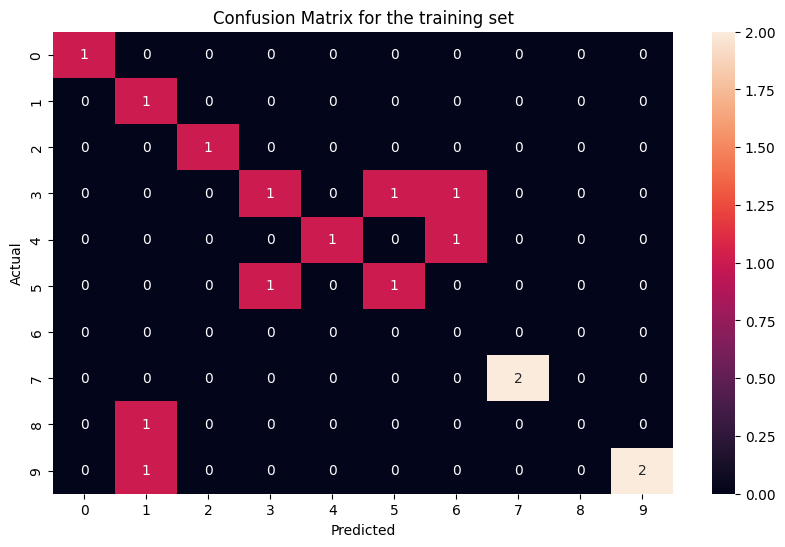

In [50]:
#Confusion Matrix for the training set
y_predtr_numpy = y_predict_train.data.cpu().numpy()
y_train_numpy = y_train.data.cpu().numpy()
cm_train = confusion_matrix(y_train_numpy, y_predtr_numpy)
plt.subplots(figsize=(10, 6))
sb.heatmap(cm_train, annot = True, fmt = 'g')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix for the training set")
plt.show()



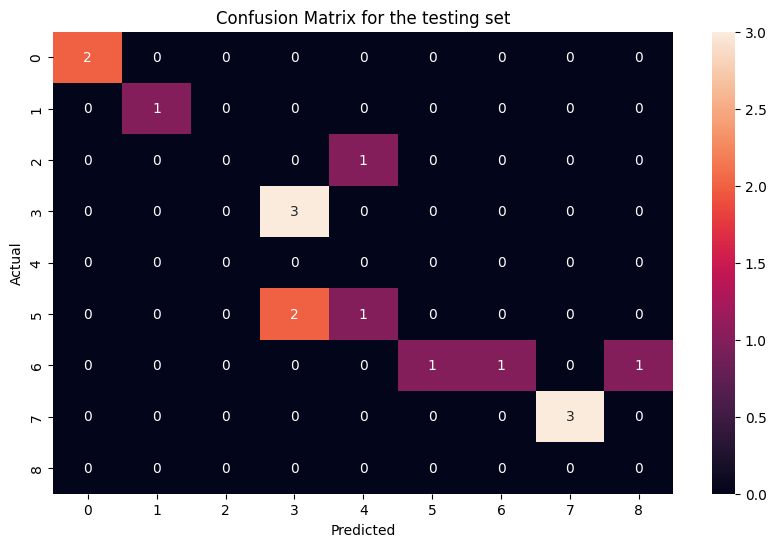

In [51]:
#Confusion Matrix for the test set
y_predts_numpy = y_predict_test.data.cpu().numpy()
y_test_numpy = y_test.data.cpu().numpy()
cm_train = confusion_matrix(y_test_numpy, y_predts_numpy)
plt.subplots(figsize=(10, 6))
sb.heatmap(cm_train, annot = True, fmt = 'g')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix for the testing set")
plt.show()